# Plotting results of predictions

Here, the outputs from `5_combine_ensembles.ipynb` are plotted. There are various types of plots, some that are used in the manuscript and some that are not




In [1]:
import folium
import odc.geo
import numpy as np
import xarray as xr
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from odc.geo.xr import assign_crs
from datacube.utils.cog import write_cog
from matplotlib.colors import ListedColormap

import sys
sys.path.append('/g/data/os22/chad_tmp/climate-carbon-interactions/src/')
from _collect_prediction_data import allNaN_arg

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

import warnings
warnings.filterwarnings("ignore")

In [2]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

distributed.nanny.memory - WARNING - Ignoring provided memory limit 200469134336 due to system memory limit of 95.00 GiB


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 24,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37915,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:41993,Total threads: 24
Dashboard: /proxy/39035/status,Memory: 95.00 GiB
Nanny: tcp://127.0.0.1:40743,


## Analysis Parameters

In [5]:
var = 'NEE'
suffix='20230910'
results_name = var+'_2003_2022_5km_LGBM_'+suffix+'.nc'
# results_name = var+'_2003_2022_1km_quantiles.nc'
# mask_path = '/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/mask_5km.nc'

# upper = var+'_2003_2021_5km_LGBM_quantiles_'+suffix+'.nc'

### Open predictions

In [6]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/climate-carbon-interactions/results/predictions/'+results_name,
                      chunks = dict(time=1)
                      )
ds = assign_crs(ds, crs='EPSG:4326')
ds.attrs['nodata'] = np.nan

### Export dataset prepared for publication

In [7]:
# ds = ds.rename('Ecosystem_respiration')
# ds.attrs['units'] = 'gC/m2/month'
# ds

In [8]:
# ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+var+'_2003_2022_1km_quantiles.nc')

## Convert to PgC/year

In [9]:
grid = ds.odc.geobox.to_crs('EPSG:3577')

In [10]:
%%time
ds = ds.odc.reproject(how=grid, resampling='bilinear')
ds = ds.compute()

/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python392/lib/python3.9/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 2.03 s, sys: 657 ms, total: 2.69 s
Wall time: 13.8 s


In [11]:
area_per_pixel = ds.geobox.resolution[1]**2

ds = ds * area_per_pixel * 1e-15 * 12

In [12]:
ds = ds.sel(time=slice('2003', '2021'))

## Fire emissions

In [13]:
fire = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/FireEmissions_10km_monthly_2003_2022.nc')
fire = fire.sum(['x', 'y'])
fire = fire*12


## Interannual variability and annual mean

In [14]:
annual_ds = ds.resample(time='1Y').sum()
annual_fire = fire.resample(time='1Y').sum()

In [15]:
# upper_percentile = (annual_ds.sel(quantile=0.75).sum(['x','y']) / 12).mean().values
# lower_percentile = (annual_ds.sel(quantile=0.25).sum(['x','y']) / 12).mean().values
print('This Study Annual Mean (median model): ',(annual_ds.sum(['x','y']) / 12).mean().values)
print('This Study Annual Mean (median model)+FIRE: ', ((annual_ds.sum(['x','y'])+annual_fire)/12).mean().values)
# print('This Study annual mean 75th percentile: ',upper_percentile)
# print('This Study annual mean 25th percentile: ',lower_percentile)
# print('IQR = ',upper_percentile-lower_percentile)

This Study Annual Mean (median model):  -1.9362307
This Study Annual Mean (median model)+FIRE:  -1.7869941


In [16]:
print('This Study IAV (median model): ',(annual_ds.sum(['x','y']) / 12).std().values)
print('This Study IAV (median model) + FIRE: ',((annual_ds.sum(['x','y'])+annual_fire)/12).std().values)

This Study IAV (median model):  0.14495635032653809
This Study IAV (median model) + FIRE:  0.1387227177619934


In [17]:
ds_clim_mean = ds.groupby('time.month').mean()
print('Seasonal range of '+var, ds_clim_mean.sum(['x','y']).max().values - ds_clim_mean.sum(['x','y']).min().values)

if var=='NEE':
    ds_1D = ds.sum(['x','y'])
    ds_fire_1d = ds_1D+fire
    ds_clim_mean_fire = ds_fire_1d.groupby('time.month').mean()
    print('Seasonal range with fire of '+var, ds_clim_mean_fire.max().values - ds_clim_mean_fire.min().values)

Seasonal range of NEE 0.46490907669067383
Seasonal range with fire of NEE 0.46584486961364746


## Anomalies

In [ ]:
# ds_clim_mean = ds.groupby('time.month').mean()
# ds_anom = (ds.groupby('time.month') - ds_clim_mean)

In [ ]:
# ds_1d = ds.sum(['x', 'y'])

# ds_fire_1d = ds_1d+fire
# ds_fire_clim_mean = ds_fire_1d.groupby('time.month').mean()
# ds_fire_anom = (ds_fire_1d.groupby('time.month') - ds_fire_clim_mean)

In [ ]:
# ds_fire_anom.sel(quantile=0.5).rolling(time=12, min_periods=12).mean().plot(figsize=(11,5))

## Zonal timeseries


In [18]:
# ds_1D = ds.sum(['x','y'])

ds_1D = ds.rename(var).sum(['x','y'])
# upper_1D = ds.sel(quantile=0.75).sum(['x','y'])
# lower_1D = ds.sel(quantile=0.25).sum(['x','y'])

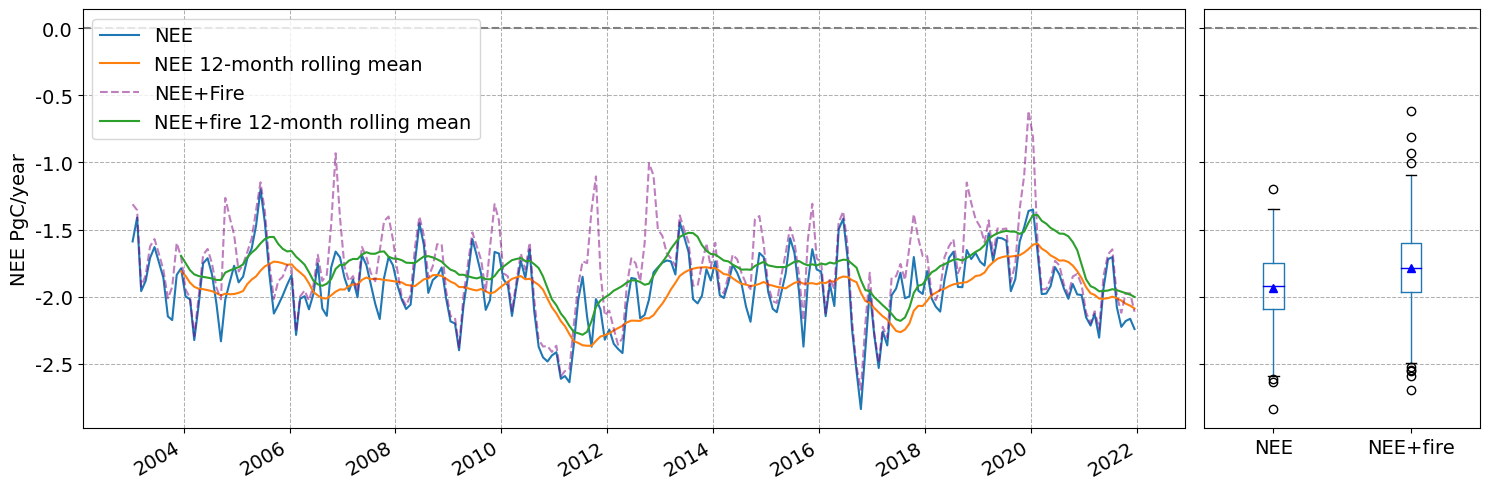

In [19]:
df_1d = ds_1D.drop('spatial_ref').to_dataframe()
if var == 'NEE':
    df_1d['NEE+fire'] = ds_fire_1d.drop('spatial_ref').to_dataframe(name='NEE+fire')

fig,ax = plt.subplots(1,2, figsize=(15,5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
ds_1D.plot(linestyle='-', ax=ax[0], label=var)
ds_1D.rolling(time=12, min_periods=12).mean().plot(ax=ax[0], label=var+' 12-month rolling mean')
# ax[0].fill_between(ds_1D.time, lower_1D, upper_1D, alpha=0.2)
df_1d.boxplot(ax=ax[1], rot=0, grid=False, fontsize=14, showmeans=True, color={'medians': 'blue'}, meanprops={'markerfacecolor': 'blue', 'markeredgecolor':'blue'})

if var == 'NEE':
    ds_fire_1d.plot(linestyle='--', ax=ax[0], label='NEE+Fire', c='purple', alpha=0.5)
    ds_fire_1d.rolling(time=12, min_periods=12).mean().plot(ax=ax[0], label='NEE+fire 12-month rolling mean')
    ax[0].axhline(0, c='grey', linestyle='--')
    ax[1].axhline(0, c='grey', linestyle='--')

if var!='NEE':
    ax[0].set_ylim(1.0, 8.0)
    
ax[0].set_ylabel(var+' PgC/year', fontsize=14)
ax[0].xaxis.set_major_locator(mdates.YearLocator(2))
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].set_yticklabels(['{:3.1f}'.format(x) for x in ax[0].get_yticks()])
ax[0].set_xlabel('')
ax[0].set_title('')
ax[0].grid('off', which='major', axis='both', linestyle='--', linewidth=0.75)
ax[1].grid('off', which='major', axis='y', linestyle='--', linewidth=0.75)
ax[0].legend(loc='best', fontsize=14)
plt.tight_layout()
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_aus_timeseries_with_boxplot_'+suffix+'.png')

## Plots per bioregion

In [20]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')
gdf.head()

,bioclimatic_regions,region_name,geometry
0,1.0,Tropics,"MULTIPOLYGON (((122.92500 -16.42500, 122.92500..."
1,2.0,Savanna,"MULTIPOLYGON (((147.67500 -19.87500, 147.72500..."
2,3.0,Warm Temperate,"MULTIPOLYGON (((145.42500 -36.02500, 145.42500..."
3,4.0,Cool Temperate,"MULTIPOLYGON (((147.07500 -43.37500, 147.12500..."
4,5.0,Mediterranean,"MULTIPOLYGON (((135.82500 -34.87500, 135.82500..."


In [ ]:
# Dictionary to save results 
results = {}
for index, row in gdf.iterrows():
    print(row['region_name'])

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    dss = ds.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({row['region_name']: dss})

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(15,10), sharex=True)

for ax, k in zip(axs.ravel(), results.keys()):
    
    _1D = results[k].sel(quantile=0.5).sum(['x','y'])
    
    _1D.plot(linestyle='--', ax=ax, label=var, )
    ax.text(.015, .95, f'Mean: {_1D.mean().values:.3f}, std: {_1D.std().values:.3f} PgC/yr',
        transform=ax.transAxes, fontdict={'fontsize': 14})
    if var=='NEE':
        ax.axhline(0, c='grey', linestyle='--')
    ax.set_title(k, fontdict={'fontsize': 14})
    ax.set_ylabel('')
    ax.set_xlabel('')

fig.supylabel(var+' PgC/year', fontsize=14)
plt.tight_layout()
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_bioregion'+suffix+'.png')

## Per-pixel summaries

In [21]:
annual_mean = ds.sel(time=slice('2003', '2021')).resample(time='1Y').sum().mean('time')
annual_std = ds.sel(time=slice('2003', '2021')).resample(time='1Y').sum().std('time')

scaled_variance = annual_std / annual_mean

In [22]:
monthly_mean = ds.sel(time=slice('2003', '2021')).groupby('time.month').mean() #.sel(time=slice('2003','2015'))

if var == 'NEE':
    max_mean_month = allNaN_arg(monthly_mean, 'month', 'min')
    # max_mean_season = allNaN_arg(monthly_season, 'season', 'min')
else:
    max_mean_month = allNaN_arg(monthly_mean, 'month', 'max')
    # max_mean_season = allNaN_arg(monthly_season, 'season', 'max')

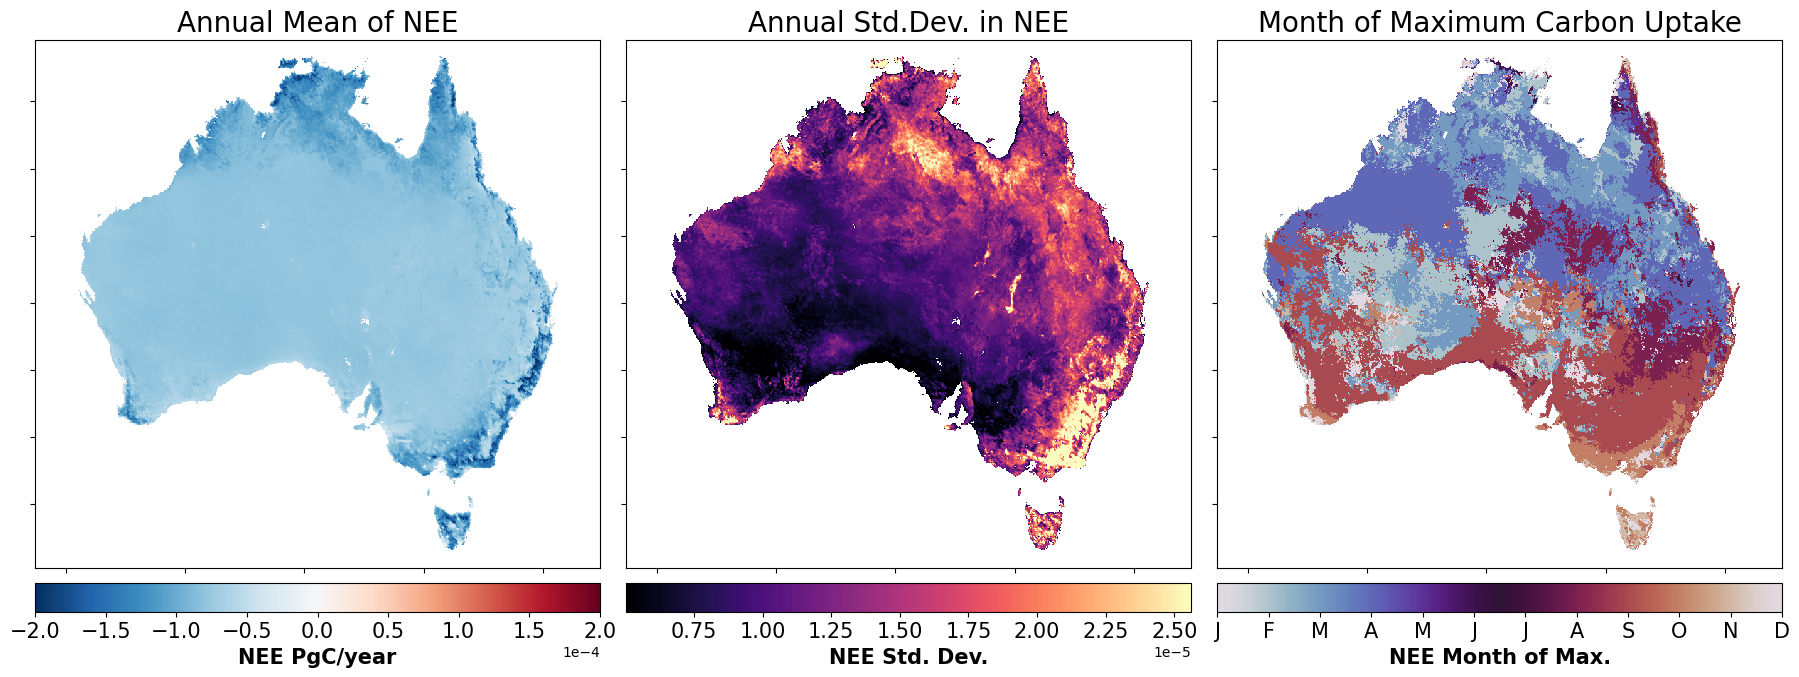

In [23]:
fig,ax = plt.subplots(1,3, figsize=(18,7), sharey=True)
font=20
vmax = 0.000025
vmin = 0
vmax_sd_nee=0.0000015
vmin_sd_nee=0
vmax_sd=0.00000275
vmin_sd=0.0000
# vmax=3e-6, vmin=-3e-6
if var == 'NEE':
    im = annual_mean.rename(var+' PgC/year').where(annual_mean!=0).plot.imshow(ax=ax[0], cmap='RdBu_r', vmax=2e-4, vmin=-2e-4, add_colorbar=False, add_labels=False)
    cbar = plt.colorbar(im, location='bottom', pad=0.025, ax=ax[0])
    cbar.set_label(label=var+' PgC/year', size=15, weight='bold')
    cbar.ax.tick_params(labelsize=15)
    cbar.formatter.set_powerlimits((0, 0))
else:
    im = annual_mean.rename(var+' PgC/year').where(annual_mean!=0).plot.imshow(ax=ax[0], cmap='viridis', robust=True, add_colorbar=False, add_labels=False)
    cbar = plt.colorbar(im, location='bottom', pad=0.025, ax=ax[0])
    cbar.set_label(label=var+' PgC/year', size=15, weight='bold')
    cbar.ax.tick_params(labelsize=15)

if var=='NEE':
    im1 = annual_std.rename('').where(annual_mean!=0).plot.imshow(ax=ax[1], cmap='magma',robust=True, add_colorbar=False, add_labels=False)
else:
    im1 = annual_std.rename('').where(annual_mean!=0).plot.imshow(ax=ax[1], cmap='magma',robust=True, add_colorbar=False, add_labels=False)

cbar1 = plt.colorbar(im1, location='bottom', pad=0.025, ax=ax[1])
cbar1.set_label(label=var+' Std. Dev.', size=15, weight='bold')
cbar1.ax.tick_params(labelsize=15)

im2 = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[2], cmap='twilight', add_colorbar=False, add_labels=False)
cbar2 = plt.colorbar(im2, spacing='uniform', ax=ax[2], location='bottom', pad=0.025)
cbar2.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
cbar2.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=15)
cbar2.set_label(label=var+' Month of Max.', size=15, weight='bold')


ax[0].set_yticklabels([])
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_xticklabels([])

ax[0].set_title('Annual Mean of '+var,fontsize=font)
ax[1].set_title('Annual Std.Dev. in '+var, fontsize=font)

if var=='NEE':
    ax[2].set_title('Month of Maximum Carbon Uptake', fontsize=font);
else:
    ax[2].set_title('Month of Maximum '+var, fontsize=font);
    
plt.tight_layout();
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_perpixel_summaries_'+suffix+'.png')

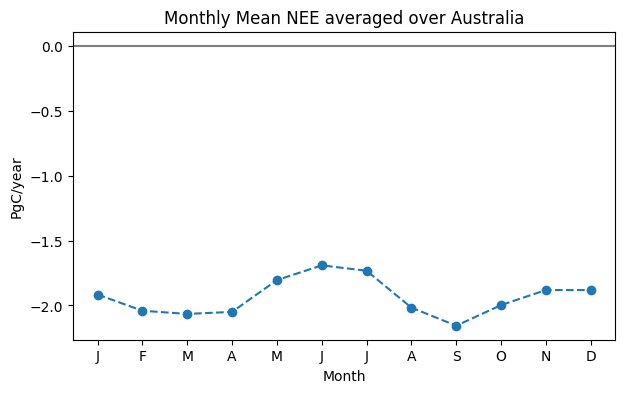

In [24]:
y = monthly_mean.sum(['x','y']).values
x = monthly_mean.month.values
# std = monthly_std.mean(['x','y']).values

fig,ax = plt.subplots(1,1, figsize=(7,4))
ax.plot(x, y, marker='o', linestyle='--')
if var=='NEE':
    ax.axhline(0, c='grey')
# ax.fill_between(x, y-std, y+std, alpha=0.5)
ax.set_title('Monthly Mean '+var+' averaged over Australia')
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 
ax.set_xlabel('Month');
ax.set_ylabel('PgC/year');


## Per bioregion climatology

In [ ]:
# Dictionary to save results 
results = {}
for index, row in gdf.iterrows():
    print(row['region_name'])

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    dss = monthly_mean.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({row['region_name']: dss})

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(12,15), sharex=True)

for ax, k in zip(axs.ravel(), results.keys()):
    
    _1D = results[k].sum(['x','y'])
    
    _1D.plot(linestyle='--', ax=ax, label=var, )
    ax.text(.015, .05, f'Mean: {_1D.mean().values:.3f}, std: {_1D.std().values:.3f} PgC/yr',
        transform=ax.transAxes, fontdict={'fontsize': 14})
    if var=='NEE':
        ax.axhline(0, c='grey', linestyle='--')
    ax.set_title(k, fontdict={'fontsize': 14})
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 
fig.supylabel(var+' PgC/year', fontsize=14)
plt.tight_layout()
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_bioregion_climatology_'+suffix+'.png')

## Interactive map

In [ ]:
# annual_ds = ds.sel(quantile=0.5).resample(time='1Y').sum()
# annual_mean = annual_ds.mean('time')
# annual_std = annual_ds.std('time')

In [ ]:
# Create folium Map (ipyleaflet is also supported)
m = folium.Map(control_scale = True)

# Plot each sample image with different colormap
# max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0], cmap='twilight', add_colorbar=False)
# np.absolute(scaled_variance).where(~mask).odc.add_to(m, opacity=1.0, cmap='magma', vmax=2)
# max_mean_month.odc.add_to(m, opacity=1.0, cmap='twilight', vmin=1, vmax=12)
# annual_std.where(annual_std>0).odc.add_to(m,  cmap='magma', robust=True, opacity=1.0) #opacity=1.0,
annual_mean.where(annual_mean!=0).odc.add_to(m, cmap='RdBu_r', vmin=-300, vmax=300)


# Zoom map to Australia
m.fit_bounds(annual_mean.odc.map_bounds())

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
       ).add_to(m)

folium.LayerControl().add_to(m)
display(m)

In [ ]:
# #queensland
# x_slice=slice(2700,4200)
# y_slice=slice(850,1800)
# name='queensland'

#SW WA
# x_slice=slice(290,900)
# y_slice=slice(2150,2510)
# name='westernaus'

#Cape York
# x_slice=slice(2600,3600)
# y_slice=slice(20,850)
# name='capeyork'

# # melbourne
# x_slice=slice(2600,3800)
# y_slice=slice(2400,2900)
# name='melbourne'

# NW WA
x_slice=slice(900,2000)
y_slice=slice(300,1000)
name='NW_WA'

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(21,7), sharey=True) # figsize=(21,6),
font=20

if var == 'NEE':
    im = annual_mean.isel(x=x_slice,
                          y=y_slice).rename(var+' gC m\N{SUPERSCRIPT TWO} y⁻¹').where(annual_mean!=0).plot.imshow(ax=ax[0],
                                                                                                                 cmap='RdBu_r',
                                                                                                                 # robust=True,
                                                                                                                  vmin=-250, vmax=250,
                                                                                                                 add_colorbar=False,
                                                                                                                 add_labels=False)
    cbar = plt.colorbar(im, location='bottom', pad=0.05, ax=ax[0])
    cbar.set_label(label=var+' gC m\N{SUPERSCRIPT TWO} year⁻¹', size=15, weight='bold')
    cbar.ax.tick_params(labelsize=15)
    # cbar.formatter.set_powerlimits((0, 0))
else:
    im = annual_mean.isel(x=x_slice, y=y_slice).rename(var+' gC m\N{SUPERSCRIPT TWO} y⁻¹').where(annual_mean!=0).plot.imshow(ax=ax[0], cmap='viridis', robust=True, add_colorbar=False, add_labels=False)
    cbar = plt.colorbar(im, location='bottom', pad=0.05, ax=ax[0])
    cbar.set_label(label=var+' gC m\N{SUPERSCRIPT TWO} y⁻¹', size=15, weight='bold')
    cbar.ax.tick_params(labelsize=15)

im2 = annual_mean.isel(x=x_slice, y=y_slice).where(annual_mean!=0).plot.imshow(ax=ax[2], cmap='viridis', robust=True, add_colorbar=False, add_labels=False)
ctx.add_basemap(ax[2], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=15)

ax[2].set_aspect('auto')
if var=='NEE':
    im1 = annual_std.isel(x=x_slice, y=y_slice).rename('').where(annual_mean!=0).plot.imshow(ax=ax[1],
                                                                                             cmap='magma',
                                                                                             robust=True,
                                                                                             # vmin=0, vmax=160,
                                                                                             add_colorbar=False,
                                                                                             add_labels=False)
else:
    im1 = annual_std.isel(x=x_slice, y=y_slice).rename('').where(annual_mean!=0).plot.imshow(ax=ax[1], cmap='magma',robust=True, add_colorbar=False, add_labels=False)

cbar1 = plt.colorbar(im1, location='bottom', pad=0.05, ax=ax[1])
cbar1.set_label(label=var+' Std. Dev.', size=15, weight='bold')
cbar1.ax.tick_params(labelsize=15)

cbar2 = plt.colorbar(im2, spacing='uniform', ax=ax[2], location='bottom', pad=0.05)


ax[0].set_ylabel('')
ax[0].set_xlabel('')
# ax[0].set_yticklabels([])
# ax[0].set_xticklabels([])
# ax[1].set_yticklabels([])
# ax[1].set_xticklabels([])
# ax[2].set_yticklabels([])
# ax[2].set_xticklabels([])

ax[0].set_title('Annual Mean of '+var,fontsize=font)
ax[1].set_title('Std.Dev. in Annual '+var, fontsize=font)

ax[2].set_title('True Colour Image', fontsize=font);
    
plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_zoomedin_perpixel_'+name+'.png')